In [1]:
#!pip install --quiet glvis
import numpy as np
import matplotlib.pyplot as plt
from  bfp import *
import mfem.ser as mfem
#from mfem.common.arg_parser import ArgParser
from glvis import glvis, GlvisData
import seaborn as sns


In [2]:
def save_angular_flux(psi, mu):
    """Saves the flux solution psi for a specific mu value to a file.

    Args:
        psi (mfem.GridFunction): The flux solution to save.
        mu (float): The mu value associated with this flux solution.
    """
    filename = "psi_mu_{:.4f}.gf".format(mu)
    psi.Save(filename)

def assemble_system(fes, marker, xs_t_coeff, dS_dE_coeff, q_coeff, v_coeff, inflow_coeff):       
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()

    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_coeff, v_coeff, -1.0), marker)
    #b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    b.Assemble()

    return A, b

def set_solver(fes, A, b, mu):
    psi = mfem.GridFunction(fes)
    psi.Assign(1.0) 
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)
   
    #psi_mu_list.append((mu, w, psi))
    
    save_angular_flux(psi, mu)
    return psi

def solve_system_for_angle(mu_vals, w_vals, mesh, fes, xs_t_coeff, S_coeff, dS_dE_coeff, q_coeff, inflow_coeff):
    psi_mu_list = []
    for mu, w in zip(mu_vals, w_vals):
        print("  Solving for mu =", mu)
        marker = get_marker_for_mu(mesh, mu)
        v_coeff = VelocityCoefficient2(mu, S_coeff)
        #v_coeff = VelocityCoefficientOld(mu, S_arr)

        A, b = assemble_system(fes, marker, xs_t_coeff, dS_dE_coeff, q_coeff, v_coeff, inflow_coeff)
        psi = set_solver(fes, A, b, mu)
        psi_mu_list.append((mu, w, psi))
    phi = mfem.GridFunction(fes)
    phi.Assign(0.0)
    for mu, w, psi in psi_mu_list:
        phi.Add(w, psi)

    phi.Save("phi.gf")
    return phi



In [3]:
# Set parameters
nx = 3
nE = 5
x_start = 0.0
x_end = 0.3
E_start = 1
E_end = 0.01
N_ang = 2
order = 1

mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()
assign_boundary_attributes(mesh, x_start, E_start, x_end, tol=1e-6)

fec = mfem.DG_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetVSize()
print("Number of unknowns:", Size)

mu_vals, w_vals = gauss_legendre_dirs(N_ang)

S_arr = np.zeros(nE)
E_arr = np.linspace(E_start, E_end, nE+1)
xs_t_coeff = TotalXSCoefficient(5)
xs_s_coeff = ScatteringXSCoefficient(0)
S_coeff    = StoppingPowerCoefficient(0)
dS_dE_arr = np.zeros(nE)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(0)
q_coeff = ConstantCoefficient(100)
inflow_coeff = ConstantCoefficient(0)
    
psi_mu_list = []

for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)
    marker = get_marker_for_mu(mesh, mu)
    v_coeff = VelocityCoefficient(mu, S_arr, E_start, E_end)

    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()

    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_coeff, v_coeff, -1.0), marker)
    #b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    b.Assemble()

    psi = mfem.GridFunction(fes)
    psi.Assign(1.0) 
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)

    
    # Append the angular solution for mu
    psi_mu_list.append((mu, w, psi))
    
    # Save each angular solution and corresponding mesh.
    psi.Save("psi_mu_list{:.3f}.gf".format(mu))

phi = mfem.GridFunction(fes)
phi.Assign(0.0)
for mu, w, psi in psi_mu_list:
    phi.Add(w, psi)

phi.Save("phi_newww.gf")
    

File '/Users/melekderman/github/BFP/examples/mesh/usr/3x5_2D.mesh' already exists.
Number of unknowns: 60
  Solving for mu = -0.5773502691896257
  Solving for mu = 0.5773502691896257


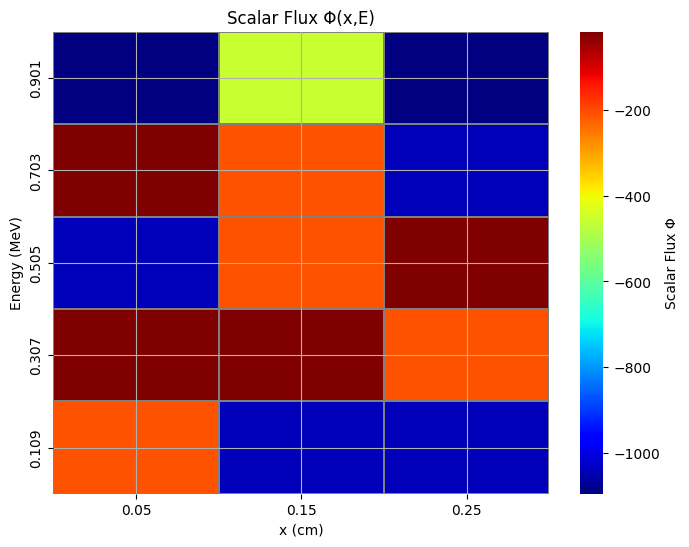

In [7]:

HeatMap = HeatmapPlot(phi, mesh, fes)
HeatMap.plot_heatmap(x_start, x_end, nx, E_start, E_end, nE)

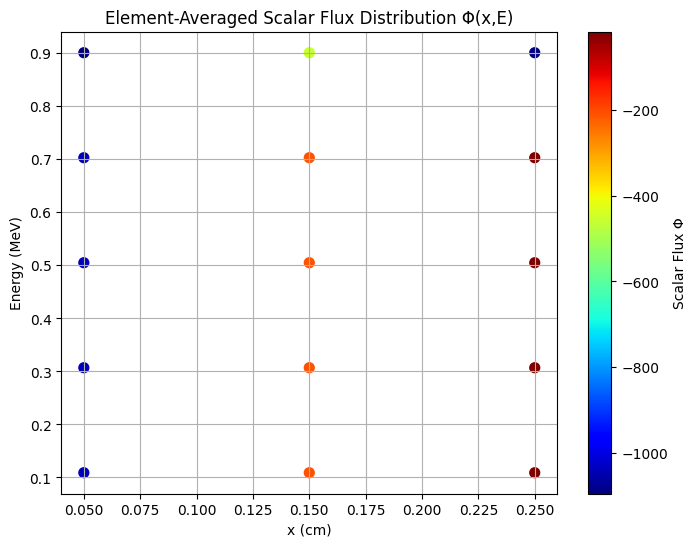

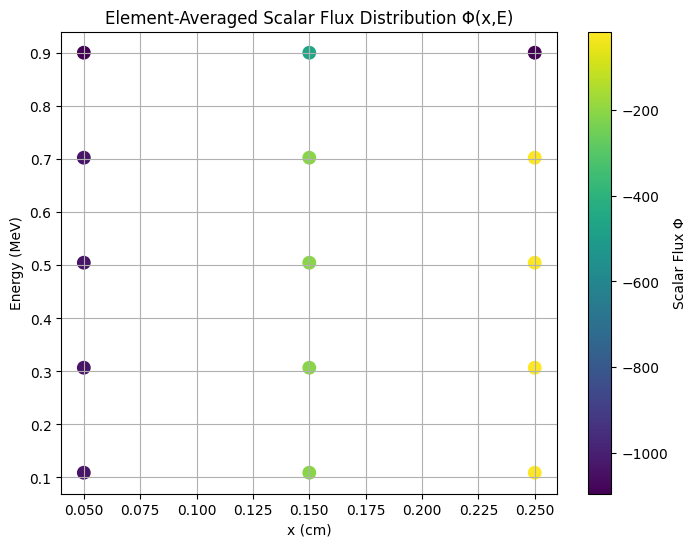

In [10]:
Scatter = ScatterPlot(phi, mesh, fes)
Scatter.plot_scatter()
Scatter.plot_scatter(cmap='viridis', point_size=80)


In [11]:
print(q_coeff.EvalValue([0, 0.5]))


100


In [40]:
print(mesh.GetNE())  # eleman sayısını kontrol et
print(mesh.Dimension()) # dimension kontrolü


200
2


In [41]:
point = [0.1, 0.5]
print("S_coeff", S_coeff.EvalValue(point))
print("xs_t_coeff", xs_t_coeff.EvalValue(point))
print("dS_dE_coeff", dS_dE_coeff.EvalValue(point))


S_coeff 0.0
xs_t_coeff 5.0
dS_dE_coeff 0.0


In [16]:


def test_TotalXSCoefficient():
    print("Running tests for TotalXSCoefficient...")

    # 1. Sabit kullanım testi
    coeff_const = TotalXSCoefficient(3.5)
    test_points = [ [0.0, 0.0], [1.0, 0.5], [0.2, 1.0] ]
    for pt in test_points:
        val = coeff_const.EvalValue(pt)
        assert val == 3.5, f"Constant test failed at {pt}, got {val}"
    print("  ✓ Constant coefficient test passed.")

    # 2. Veri tabanlı kullanım testi
    # xs_t_data: 5 enerji grubu için rastgele (veya test için sabit) değerler
    xs_t_data = [1.0, 2.0, 3.0, 4.0, 5.0]
    E_start = 0.0
    E_end = 10.0
    coeff_data = TotalXSCoefficient(xs_t_data, E_start, E_end)

    # Her grup için ortadaki bir enerji noktasını test edelim:
    n_groups = len(xs_t_data)
    for i in range(n_groups):
        # E'nin bu grup içine düşmesi için E'yi bu grubun merkezine ayarlayalım
        E = E_start + (i + 0.5) * (E_end - E_start) / n_groups
        y = (E - E_start) / (E_end - E_start)  # normalize y ∈ [0,1]
        x = [0.0, y]
        val = coeff_data.EvalValue(x)
        expected = xs_t_data[i]
        assert np.isclose(val, expected), f"Data coefficient test failed at group {i}, got {val}, expected {expected}"
    print("  ✓ Data-based coefficient test passed.")

    print("All tests passed successfully.")

# Test fonksiyonunu çağır
test_TotalXSCoefficient()


Running tests for TotalXSCoefficient...
  ✓ Constant coefficient test passed.
  ✓ Data-based coefficient test passed.
All tests passed successfully.


In [ ]:
xs_t_data = [0,1,2,3,4]
E_deneme = np.linspace(1, 0.01, 6)
E_deneme

array([1.   , 0.802, 0.604, 0.406, 0.208, 0.01 ])

In [ ]:
def test_TotalXSCoefficient_descending_energy_groups():
    print("Running test for descending energy groups...")

    xs_t_data = [0, 1, 2, 3, 4]  # grup değerleri
    E_start = 1.0
    E_end = 0.01
    coeff = TotalXSCoefficient(xs_t_data, E_start, E_end)

    # Grup sınırlarının orta noktalarını test edelim (beklenen grup numaralarıyla)
    test_cases = [
        (1.0, 0),    # sınır noktası
        (0.9, 0),    # Grup 0
        (0.7, 1),    # Grup 1
        (0.5, 2),    # Grup 2
        (0.3, 3),    # Grup 3
        (0.1, 4),    # Grup 4
        (0.208, 4),  # sınır noktasında da doğru grup mu
    ]

    for E, expected_group in test_cases:
        # Normalize edilmiş y değerini hesapla
        y = (E - E_start) / (E_end - E_start)
        x = [0.0, y]  # spatial x[0] kullanılmıyor
        val = coeff.EvalValue(x)
        assert int(val) == expected_group, f"Test failed at E={E:.3f} (y={y:.3f}): got {val}, expected {expected_group}"

    print("  ✓ Descending energy group mapping test passed successfully.")

if __name__ == "__main__":
    test_TotalXSCoefficient_descending_energy_groups()


Running test for descending energy groups...
  ✓ Descending energy group mapping test passed successfully.


In [ ]:
import math

import numpy as np
import mfem.ser as mfem  # ya da uygun MFEM Python binding modülü
import math

import numpy as np
import mfem.ser as mfem  # Adjust this import as needed for your MFEM Python binding

class TotalXSCoefficient9(mfem.PyCoefficient):
    """
    Coefficient for the total cross-section Σ_t(E).

    This class divides the energy range [E_start, E_end] into N groups
    (where N = len(xs_t_data)) by generating N+1 bin boundaries:

    """
    
    def __init__(self, xs_t_data, E_start, E_end):
        super(TotalXSCoefficient9, self).__init__()
        self.xs_t_data = xs_t_data
        self.E_start = E_start
        self.E_end = E_end
        self.n_groups = len(xs_t_data)
        # Create N+1 energy bin boundaries
        self.E_bins = np.linspace(E_start, E_end, self.n_groups + 1)
    
    def EvalValue(self, x):
        """
        x[1] is assumed to be the physical energy E.
        The function returns the corresponding group value from xs_t_data based on
        the half-open intervals defined by E_bins.
        """
        E = x[1]
        if E > self.E_start:
            E = self.E_start
        if E < self.E_end:
            E = self.E_end
        
        for i in range(self.n_groups - 1):
            if i == 0:
                if self.E_bins[0] >= E and E >= self.E_bins[1]:
                    if E == self.E_bins[1]:
                        continue
                    return float(self.xs_t_data[0])
            else:
                if self.E_bins[i] >= E and E >= self.E_bins[i+1]:
                    # If E equals the lower bound, assign it to the next group.
                    if E == self.E_bins[i+1]:
                        continue
                    return float(self.xs_t_data[i])
                
        if self.E_bins[-2] >= E and E >= self.E_bins[-1]:
            return float(self.xs_t_data[-1])
        
        return float(self.xs_t_data[-1])




def test_TotalXSCoefficient():
    xs_t_data = [0,1,2,3,4]
    coeff = TotalXSCoefficient9(xs_t_data, 1, 0.01)
    print(coeff.EvalValue([0.0, 1]))
    print(coeff.EvalValue([0.0, 0.802]))
    print(coeff.EvalValue([0.0, 0.207]))
    print(coeff.EvalValue([0.0, 0.01]))


test_TotalXSCoefficient()

0.0
1.0
4.0
4.0


In [104]:
xs_t_data = [0,1,2,3,4]
E_deneme = np.linspace(1, 0.01, 6)
E_deneme

array([1.   , 0.802, 0.604, 0.406, 0.208, 0.01 ])